Total de imagens encontradas: 981
Mapping de classes (string -> número): {'bom': 0, 'ruim': 1}
Imagens de treino: 687
Imagens de validação: 147
Imagens de teste: 147
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPoo

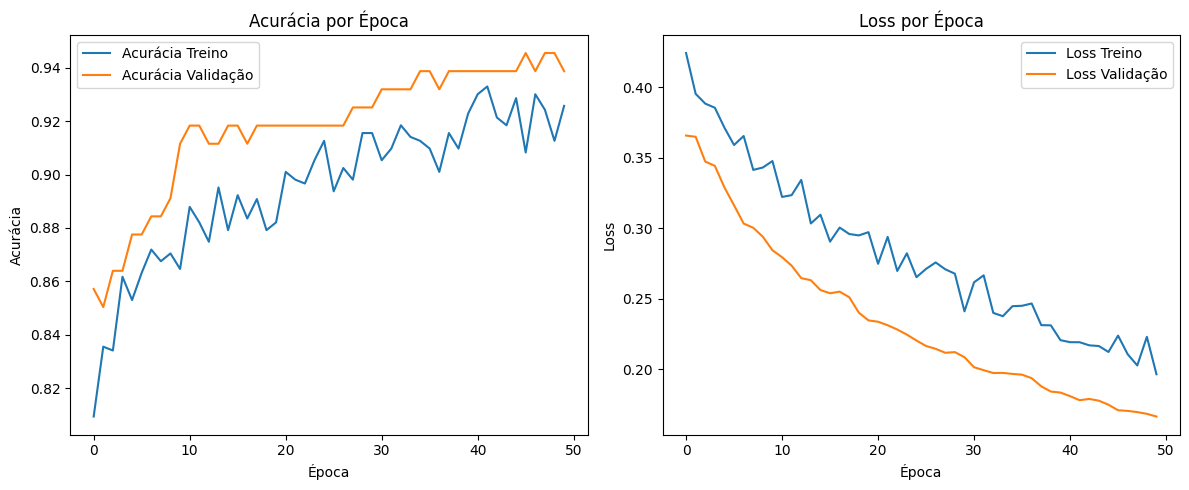

5/5 [==============================] - 0s 11ms/step - loss: 0.2129 - accuracy: 0.9184
Perda no conjunto de teste: 0.2129
Acurácia no conjunto de teste: 0.9184
Modelo refinado salvo em 'modelo_cnn_ckplus_finetuned_augmentation_earlystop.h5'


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# ===============================
# Definições de paths e parâmetros
# ===============================
DATA_DIR = r'C:\Users\Caio Burton\Documents\dataset_visao\ck+'
IMG_HEIGHT, IMG_WIDTH = 48, 48
BATCH_SIZE = 32
EPOCHS = 50  # Pode definir um número maior para permitir o early stop
SEED = 42

# ===============================
# Mapeamento das classes
# ===============================
mapping = {
    'happy': 'bom',
    'surprise': 'bom',
    'sadness': 'ruim',
    'disgust': 'ruim',
    'fear': 'ruim',
    'anger': 'ruim',
    'contempt': 'ruim'
}
novas_classes = ['bom', 'ruim']
label_to_index = {nome: idx for idx, nome in enumerate(novas_classes)}

# ===============================
# 1. Função para listar imagens e rótulos
# ===============================
def listar_imagens_e_rotulos(data_dir, mapping):
    image_paths = []
    labels = []
    for emotion in os.listdir(data_dir):
        emotion_path = os.path.join(data_dir, emotion)
        if not os.path.isdir(emotion_path):
            continue
        if emotion not in mapping:
            print(f'Ignorando a emoção {emotion} que não está mapeada.')
            continue
        novo_rotulo = mapping[emotion]
        for file in os.listdir(emotion_path):
            if file.lower().endswith('.png'):
                image_paths.append(os.path.join(emotion_path, file))
                labels.append(label_to_index[novo_rotulo])
    return image_paths, labels

image_paths, labels = listar_imagens_e_rotulos(DATA_DIR, mapping)
print(f"Total de imagens encontradas: {len(image_paths)}")
print("Mapping de classes (string -> número):", label_to_index)

# ===============================
# 2. Embaralhar e dividir dataset
# ===============================
TEST_SPLIT = 0.15
VALID_SPLIT = 0.15
num_total = len(image_paths)
num_test = int(TEST_SPLIT * num_total)
num_val = int(VALID_SPLIT * num_total)
num_train = num_total - num_val - num_test

# Embaralhar
combined = list(zip(image_paths, labels))
random.seed(SEED)
random.shuffle(combined)
image_paths[:], labels[:] = zip(*combined)

# Dividir
train_paths = image_paths[:num_train]
train_labels = labels[:num_train]
val_paths = image_paths[num_train:num_train + num_val]
val_labels = labels[num_train:num_train + num_val]
test_paths = image_paths[num_train + num_val:]
test_labels = labels[num_train + num_val:]

print(f"Imagens de treino: {len(train_paths)}")
print(f"Imagens de validação: {len(val_paths)}")
print(f"Imagens de teste: {len(test_paths)}")

# ===============================
# 3. Função de leitura e pré-processamento básico
# ===============================
def ler_e_preprocessar_imagem(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)  # grayscale
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image, label

# ===============================
# 4. Data Augmentation
# ===============================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),  # flip horizontal
    layers.RandomRotation(0.1),       # rotaciona em ~10%
    layers.RandomZoom(0.1),          # zoom ±10%
])

def augment_image(image, label):
    # Aplique a camada de augmentation somente no dataset de treino
    image = data_augmentation(image, training=True)
    return image, label

# ===============================
# 5. Criando os Datasets
# ===============================
def criar_dataset(image_paths, labels, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(labels)))
    dataset = dataset.map(ler_e_preprocessar_imagem, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_ds = criar_dataset(train_paths, train_labels, augment=True)
train_ds = train_ds.shuffle(1000, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = criar_dataset(val_paths, val_labels, augment=False)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = criar_dataset(test_paths, test_labels, augment=False)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ===============================
# 6. Carregar Modelo Pré-Treinado (FER2013)
# ===============================
pretrained_model_path = 'fer2013_cnn_model.h5'
model = keras.models.load_model(pretrained_model_path)

# Se quiser descongelar mais camadas, faça algo como:
# for layer in model.layers[-5:]:
#     layer.trainable = True

model.summary()

# ===============================
# 7. Compilar e treinar com Early Stopping
# ===============================
# Crie a callback de EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',       # ou 'val_accuracy', conforme sua preferência
    patience=5,               # número de épocas sem melhora para parar
    restore_best_weights=True # restaura os melhores pesos (melhor val_loss)
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stop]  # Adicione aqui a callback
)

# ===============================
# 8. Plotar histórico
# ===============================
def plotar_historico(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss Treino')
    plt.plot(history.history['val_loss'], label='Loss Validação')
    plt.title('Loss por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plotar_historico(history)

# ===============================
# 9. Avaliação e salvamento
# ===============================
resultados = model.evaluate(test_ds)
print(f"Perda no conjunto de teste: {resultados[0]:.4f}")
print(f"Acurácia no conjunto de teste: {resultados[1]:.4f}")

model.save('modelo_cnn_ckplus_finetuned.h5')
print("Modelo refinado salvo em 'modelo_cnn_ckplus_finetuned_augmentation_earlystop.h5'")
